In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sns
import netCDF4
from glob import glob 
import cmocean
from xgcm import Grid
import mplsettings

import momlevel as ml # Use Wright EOS

import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
#sns.set_style('white')
#sns.set_context('paper', font_scale=3)
#sns.set_palette('hls', 4)
#sns.set_style('ticks')

In [3]:
# static file 
fname_static = "/net/smg/OWG/CM4_highres/grids/p125/ocean_annual.static.nc"
static       = xr.open_mfdataset(fname_static)

In [4]:
# create a grid using xgcm 

coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
}
     
metrics = {
    'X': ["dxt", "dxCu", "dxCv"],
    'Y': ["dyt", "dyCu", "dyCv"]
}

grid = Grid(static, coords=coords, metrics=metrics, periodic=['X'])

In [5]:
# dataset in rho2

dir    = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_rho2/av/annual_10yr"
files  = glob(f"{dir}/ocean_annual_rho2.1940-1949.ann.nc")
files += glob(f"{dir}/ocean_annual_rho2.1950-1959.ann.nc")
files += glob(f"{dir}/ocean_annual_rho2.1960-1969.ann.nc")

ds = xr.open_mfdataset(files)
ds = ds.drop_dims('nv')

for coord in ["xh", "yh", "xq", "yq"]:
    static[coord] = ds[coord]

ds = ds.assign_coords({'geolon_u': static['geolon_u'],
                       'geolat_u': static['geolat_u'],
                       'geolon_v': static['geolon_v'],
                       'geolat_v': static['geolat_v'],
                       'geolon'  : static['geolon'],
                       'geolat'  : static['geolat']
                       })

vmo  = ds['vmo'].mean(dim='time')
thk  = ds['thkcello'].mean(dim='time')

In [6]:
vmo  = vmo.where(vmo < 1e14)
thk  = thk.where(thk < 1e10)
zrho = thk.mean(dim='xh').cumsum(dim='rho2_l')

vmo_xsum = vmo.sum(dim='xh') 
psi      = (vmo_xsum.cumsum(dim='rho2_l') - vmo_xsum.sum(dim='rho2_l'))/1e9 + 0.1 
psi.name = 'meridional-sigma2 overturning'

# add a depth coordinate to psi, with depth 
# defined by zonal mean of the time mean depth of rho
psi.coords['depth'] = grid.interp(zrho, 'Y', boundary='extend')

psi.load()
zrho.load()




<xarray.DataArray 'thkcello' (rho2_l: 74, yh: 2240)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.2943154e-03,
        2.9653991e-03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1731197e-02,
        7.8952946e-03, 5.4690299e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4592554e-02,
        1.0326770e-02, 1.9663866e-03],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8013596e+03,
        1.8068652e+03, 1.8047958e+03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8013678e+03,
        1.8068750e+03, 1.8048040e+03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8013754e+03,
        1.8068845e+03, 1.8048165e+03]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
  * rho2_l   (rho2_l) float64 1.004e+03 1.014e+03 ... 1.038e+03 1.038e+03

In [7]:
# dataset in z for getting background sigma2000

dirz    = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/av/annual_10yr"
filesz  = glob(f"{dirz}/ocean_annual_z.1940-1949.ann.nc")
filesz += glob(f"{dirz}/ocean_annual_z.1950-1959.ann.nc")
filesz += glob(f"{dirz}/ocean_annual_z.1960-1969.ann.nc")

dsz = xr.open_mfdataset(filesz)
dsz = dsz.drop_dims('nv')
dsz = dsz.assign_coords({'geolon_u': static['geolon_u'],
                         'geolat_u': static['geolat_u'],
                         'geolon_v': static['geolon_v'],
                         'geolat_v': static['geolat_v'],
                         'geolon'  : static['geolon'],
                         'geolat'  : static['geolat']
                       })

toz    = dsz['thetao'].mean(dim='time') 
soz    = dsz['so'].mean(dim='time') 
sigmaz = ml.derived.calc_pdens(toz, soz, level=2000.0) - 1000.0

In [8]:
mask   = toz/toz
delz   = xr.DataArray(np.diff(dsz['z_i']), dims='z_l')
dvol   = delz * mask * static['areacello'] 
sigmaz_dvol = sigmaz * dvol
sigmaz_xave = sigmaz_dvol.sum(dim='xh')/dvol.sum(dim='xh')
sigmaz_xave.load()

/nbhome/smg/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (z_l: 35, yh: 2240)>
array([[        nan,         nan,         nan, ..., 35.84512537,
        35.85055716, 35.86101927],
       [        nan,         nan,         nan, ..., 35.91918937,
        35.92451443, 35.93541024],
       [        nan,         nan,         nan, ..., 36.11619156,
        36.11864222, 36.11484688],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

/vftmp/Stephen.Griffies/pid17914/ipykernel_81029/188767307.py:18: UserWarning: linewidths is ignored by contourf
  p = plt.contourf(xcoord,ycoord,field,


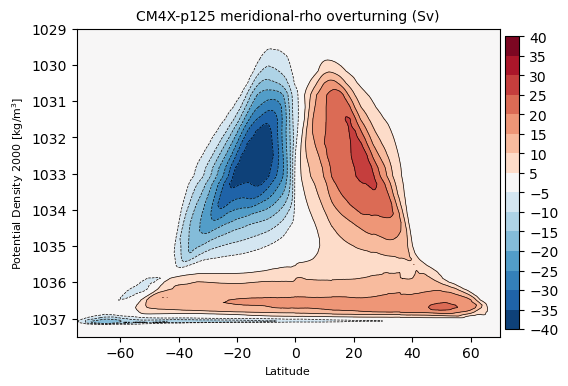

In [20]:
# meridional-rho overturning 

# for southern ocean moc 
levels  = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]
clevels = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]

# for global moc 
levels  = [-40,-35,-30,-25,-20,-15,-10,-5,5,10,15,20,25,30,35,40]
clevels = [-40,-35,-30,-25,-20,-15,-10,-5,5,10,15,20,25,30,35,40]


fig, axis = plt.subplots(1,1, figsize=(6.5,4))
field  = psi
ycoord = psi['rho2_l']
xcoord = static['yq']
xcoordmesh,ycoordmesh = np.meshgrid(xcoord,ycoord)

p = plt.contourf(xcoord,ycoord,field,
                 cmap='RdBu_r',
                 levels=levels, 
                 linewidths=0.25,
                )
plt.contour(xcoordmesh,ycoordmesh,field,clevels,colors='k',linewidths=0.5)
#plt.xlim((-75,-30))
plt.xlim((-75,70))
plt.ylim((1029,1037.5))
plt.gca().invert_yaxis()

axis.set_ylabel("Potential Density 2000 [kg/m$^3$]",fontsize=8)
axis.set_xlabel("Latitude",fontsize=8)
axis.set_facecolor('gray')
axis.set_title("CM4X-p125 meridional-rho overturning (Sv)",fontsize=10)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', 
                    shrink=0.95,orientation='vertical')
cbar.set_ticks(clevels)

plt.show()
fig.savefig('CM4Xp125_moc_rho.png', bbox_inches='tight', dpi=300)

/vftmp/Stephen.Griffies/pid17914/ipykernel_81029/1331733022.py:17: UserWarning: linewidths is ignored by contourf
  p = plt.contourf(xcoord,ycoord,field,


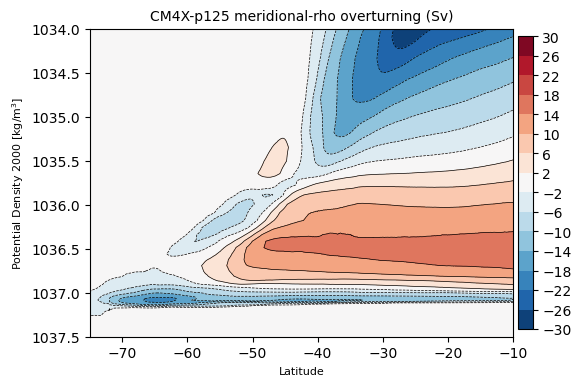

In [17]:
# meridional-rho overturning 

# for global moc 
levels  = [-40,-35,-30,-25,-20,-15,-10,-5,5,10,15,20,25,30,35,40]
clevels = [-40,-35,-30,-25,-20,-15,-10,-5,5,10,15,20,25,30,35,40]

# for southern ocean moc 
levels  = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]
clevels = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]

fig, axis = plt.subplots(1,1, figsize=(6.5,4))
field  = psi
ycoord = psi['rho2_l']
xcoord = static['yq']
xcoordmesh,ycoordmesh = np.meshgrid(xcoord,ycoord)

p = plt.contourf(xcoord,ycoord,field,
                 cmap='RdBu_r',
                 levels=levels, 
                 linewidths=0.5,
                )
plt.contour(xcoordmesh,ycoordmesh,field,clevels,colors='k',linewidths=0.5)
plt.xlim((-75,-10))
#plt.ylim((1030,1037.5))
plt.ylim((1034,1037.5))
plt.gca().invert_yaxis()

axis.set_ylabel("Potential Density 2000 [kg/m$^3$]",fontsize=8)
axis.set_xlabel("Latitude",fontsize=8)
axis.set_facecolor('gray')
axis.set_title("CM4X-p125 meridional-rho overturning (Sv)",fontsize=10)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', 
                    shrink=0.95,orientation='vertical')
cbar.set_ticks(clevels)

plt.show()
fig.savefig('CM4Xp125_somoc_rho.png', bbox_inches='tight', dpi=300)

/nbhome/smg/envs/py310/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2141: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


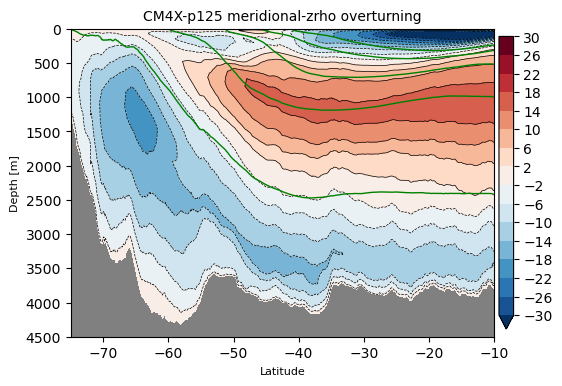

In [21]:
# meridional-rho overturning on zrho

# for global moc 
levels  = [-40,-35,-30,-25,-20,-15,-10,-5,5,10,15,20,25,30,35,40]
clevels = [-40,-35,-30,-25,-20,-15,-10,-5,5,10,15,20,25,30,35,40]

# for southern ocean moc 
levels   = [-30,-26,-22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]
clevels  = levels 
sigmalev = [35, 35.5, 36, 36.5, 37]

fig, axis = plt.subplots(1,1, figsize=(6.5,4))
field = psi

p=xr.plot.contourf(field, ax=axis, x="yq", y="depth",
                 cmap='RdBu_r',
                 levels=levels, 
                 linewidths=0.25,
                 add_colorbar=False
                )

pc=xr.plot.contour(field, ax=axis, x="yq", y="depth",
                  yincrease=False, 
                  linewidths=.5,
                  levels=clevels, 
                  colors='k'
                 )

field2 = sigmaz_xave
pcc=xr.plot.contour(field2, ax=axis, x="yh", y="z_l",
                 linewidths=1,
                 colors='g',
                 levels=sigmalev,
                 yincrease=False)
                
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', 
                    shrink=0.95,orientation='vertical')
cbar.set_ticks(levels)
    
plt.xlim((-75,-10))
plt.ylim((0,4500))
plt.gca().invert_yaxis()

axis.set_ylabel("Depth [m]",fontsize=8)
axis.set_xlabel("Latitude",fontsize=8)
axis.set_facecolor('gray')
axis.set_title("CM4X-p125 meridional-zrho overturning",fontsize=10)

plt.show()
fig.savefig('CM4Xp125_somoc_zrho.png', bbox_inches='tight', dpi=300)
fig.savefig('CM4Xp125_somoc_zrho.pdf', bbox_inches='tight', dpi=300)


/nbhome/smg/envs/py310/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2141: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


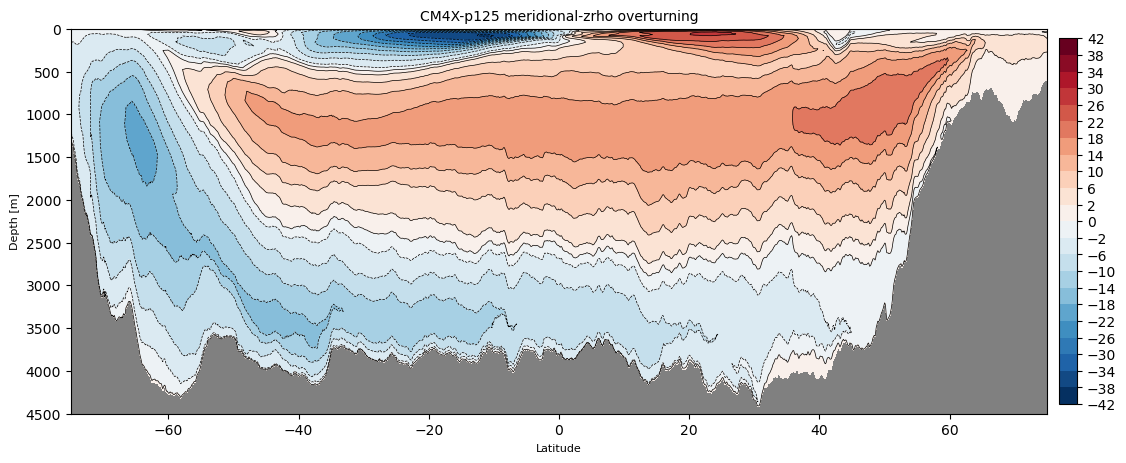

In [23]:
# meridional-rho overturning on zrho

# for southern ocean moc 
levels  = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]
clevels = [35, 35.25, 35.5, 35.75, 36, 36.25, 36.5, 36.75, 37, 37.25]
clevels = [35, 35.5, 36, 36.5, 37]

# for global moc 
levels = [-42, -38, -34, -30, -26, -22, -18, -14, -10, -6, -2, 0, 2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42]
clevels = levels 


fig, axis = plt.subplots(1,1, figsize=(15,5))
field = psi

p=xr.plot.contourf(field, ax=axis, x="yq", y="depth",
                 cmap='RdBu_r',
                 levels=levels, 
                 linewidths=0.25,
                 add_colorbar=False
                )

cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', 
                    shrink=0.95,orientation='vertical')
cbar.set_ticks(levels)

pc=xr.plot.contour(field, ax=axis, x="yq", y="depth",
                  yincrease=False, 
                  linewidths=.5,
                  levels=levels,
                  colors='k'
                 )

#field2 = sigmaz_xave
#pcc=xr.plot.contour(field2, ax=axis, x="yh", y="z_l",
#                 linewidths=1,
#                 colors='g',
#                 levels=sigmalev,
#                 yincrease=False)


plt.xlim((-75,75))
plt.ylim((0,4500))
plt.gca().invert_yaxis()

axis.set_ylabel("Depth [m]",fontsize=8)
axis.set_xlabel("Latitude",fontsize=8)
axis.set_facecolor('gray')
axis.set_title("CM4X-p125 meridional-zrho overturning",fontsize=10)
#axis.text(.78,.01, 'For years 1981-2010',fontsize=8, transform=axis.transAxes)

plt.show()
fig.savefig('CM4Xp125_moc_zrho.png', bbox_inches='tight', dpi=300)
fig.savefig('CM4Xp125_moc_zrho.pdf', bbox_inches='tight', dpi=300)